# True Wind

Please read the notebook [Boat Instruments](Boat_Instruments.ipynb) first.  In this notebook we will mostly use the smoothed (processed) versions of AWA, AWS, etc discussed in that previous notebook.

## Summary

We will investigate the computation of TWA/TWD/TWS.  Naive approaches, while they work reasonably well, will not match what is computed on the boat.  

An alternative approach has a much more complex derivation, but it matches the boat estimates near perfectly and is nevertheless fairly simple to implement.

Finally, we will modify the approach used on the boat to address significant flaws in the estiamte of TWD.


## Glossary

### Instruments and their Measurements
- AWA: apparent wind angle, the angle of the wind blowing at the top the mast (fast but noisy)
- AWS: apparent wind speed, the speed at the mast head (fast and noisy)
- SPD: boat speed **through the water** measured with the paddle wheel speedo in the hull (fast and noisy)
- HDG: compass heading (on PG this is magnetic northa and not true north, though easily corrected using magnetic variation/declination).
- COG and SOG: course and speed over ground from the GPS (these are relative to true north not magnetic on PG). These can differ from HDG/SPD because of current and leeway.

### Computed Quantities
- TWS: true wind speed, the speed of the wind over the ground (computed from the above quantities using the "wind triangle").
- TWD: true wind direction, the angle of the wind blowing over the ground (see "wind triangle").
- TWA: true wind angle, the angle of the wind over the ground reported relative the orientation of the boat (same)

In [1]:
# Load some libraries
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
from numba import jit

# These are libraries written for RaceAnalysis
from global_variables import G
import race_logs
import process as p
import analysis as a
import chart as c
from utils import DictClass

G.init_seattle(logging_level="INFO")

In [2]:
import importlib
importlib.reload(race_logs)

<module 'race_logs' from '/Users/viola/GDrive/Sailboat/Code/Python/sailing/race_logs.py'>

In [3]:
dfs, races, big_df = race_logs.read_dates(["2019-12-07", "2019-11-16"], compute_true_wind=False)
df = dfs[1]

2020-06-14 14:24:58,861|INFO|read_metadata| Read 51 records.
2020-06-14 14:24:58,862|INFO|read_logs| Reading file 2019-12-07_09:47.pd.gz


Session from 2019-12-07 17:47:04, 124084 rows, 3.4466666666666668 hours.


2020-06-14 14:25:00,740|INFO|read_logs| Found 124076 records before trim.
2020-06-14 14:25:00,758|INFO|read_logs| Trimming to 54316 109378
2020-06-14 14:25:00,759|INFO|read_logs| Reading file 2019-11-16_10:09.pd.gz


Session from 2019-11-16 18:09:15.020000, 128865 rows, 3.5797222222222222 hours.


2020-06-14 14:25:01,609|INFO|read_logs| Found 126190 records before trim.
2020-06-14 14:25:01,625|INFO|read_logs| Trimming to 41076 111668


<IPython.core.display.Javascript object>


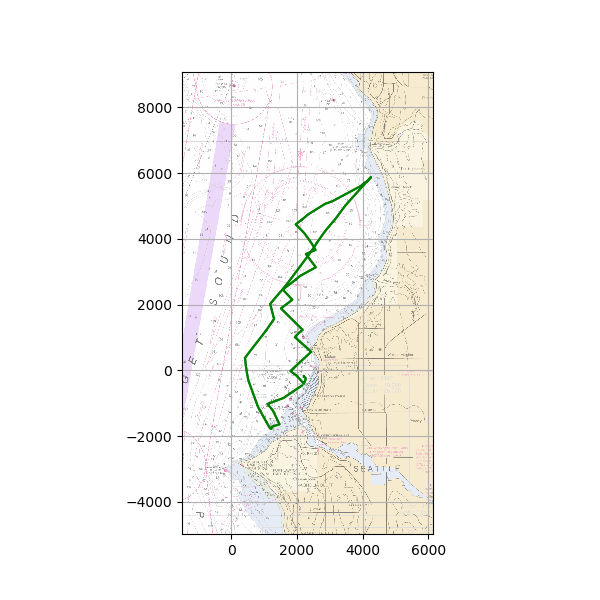

{'lat_max': 47.76891304,
 'lat_min': 47.642535360000004,
 'lon_max': -122.35657114,
 'lon_min': -122.45864216,
 'proj': ' +proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datum=WGS84 +units=m +no_defs ',
 'pixels': 2000,
 'south': -4975.696256507495,
 'north': 9073.001994818736,
 'east': 6149.557132226704,
 'west': -1502.0489317048778,
 'path': '/tmp/mbtile.tif',
 'source': 'Data/MBTILES/MBTILES_06.mbtiles',
 'image': array([[[247, 247, 247],
         [173, 173, 173],
         [237, 237, 237],
         ...,
         [239, 216, 163],
         [239, 216, 163],
         [239, 216, 163]],
 
        [[229, 229, 229],
         [201, 201, 201],
         [253, 253, 253],
         ...,
         [239, 216, 163],
         [239, 216, 163],
         [239, 216, 163]],
 
        [[211, 120, 169],
         [236, 219, 228],
         [255, 255, 255],
         ...,
         [239, 216, 163],
         [239, 216, 163],
         [239, 216, 163]],
 
        ...,
 
        [[255, 255, 255],
     

In [4]:
chart = c.plot_chart(df)
c.draw_track(df, chart, color='green')

## Apparent vs. True Wind

![im](Data/Images/out.png)

Apparent wind conflates the "true wind" and boat movement.  If the boat were stationary (e.g. at the dock) the apparent wind and the true wind are the same (both in speed and direction).  But if the boat is moving it induces apparent "wind" which is equal and opposite to the boat's speed and direction (when you stick your hand out the window of your car on the highway you observe the car's apparent wind).  **True Wind** is an attempt to subtract the boat's motion.

Note, AWA, AWS, and SPD are directly measured by sensor units on the boat.  True wind must be computed.

True wind is valuable in part because it is more consistent and drives the strategy that you use on the race course.  Note TWA is reported relative to the boat, and TWD is reported relative to true north. We will see that they are otherwise the same.

We can compute the TWA from AWA/AWS/SPD using the code below.  It is basic vector addition (and trigonometry).

My preferred way to do this is to separate the two components of the apparent wind: i) the wind along the boat (which I think of as "boat north" pointing to the BOW) and ii) the wind perpedicular to the boat, "boat east" or PORT.  The SPD is then subtracted from boat north (since the boat is assumed to be moving forward in the "boat north" coordinates, though there may be [Leeway](https://en.wikipedia.org/wiki/Leeway) or current). All of this can be transformed into global north by adding the boats heading (which we will not do here).  Note, heading (HDG) is reported in magnetic coordinates, not true north, so be careful to add in the magnetic variation.

For more information on sailing instruments the book *Sail Smart: Understand Your Instruments to Sail Faster, Make the Right Calls & Win Races* by Mark Chisnell provides quite a bit of helpful info on boat instruments and measurements. [link](https://www.amazon.com/dp/B07F3CKRLH/ref=cm_sw_em_r_mt_dp_U_Px-gEbZJ52RTX).  The book is short, and for some it will repeat a lot of the basics, but it is helpful none the less.

<IPython.core.display.Javascript object>


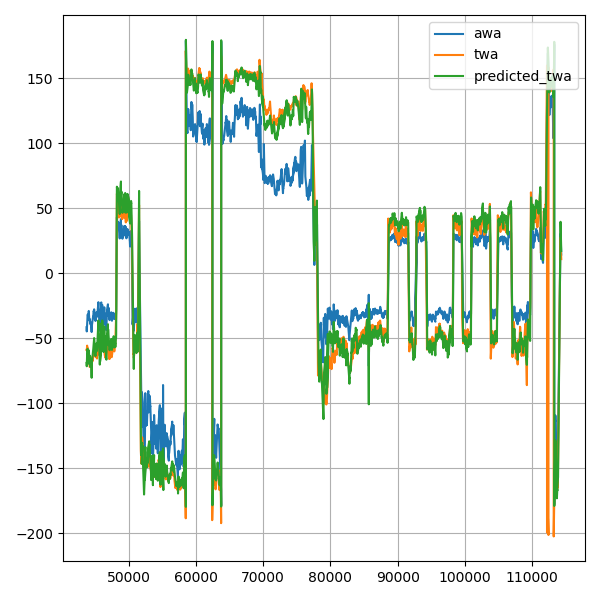

<IPython.core.display.Javascript object>


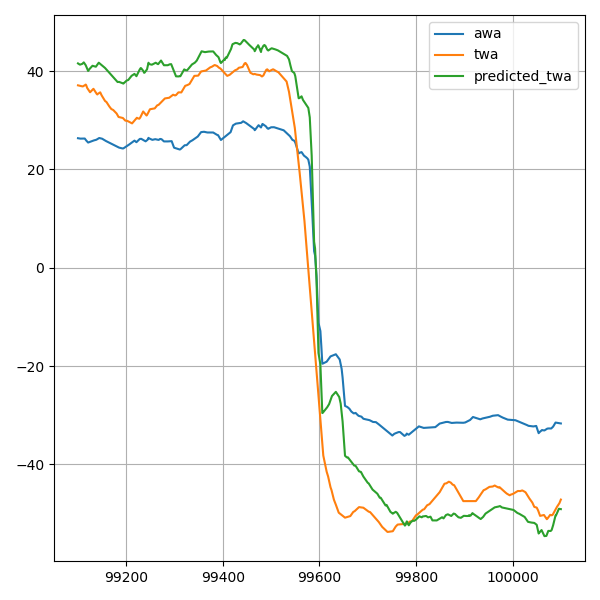

In [5]:
# TWA is computed from AWA, AWS, and boat speed (SPD)
#
# Let's break apparent wind into two components, "boat north" and "boat east".  
# Boat north points to the bow.  Boat east points to starboard.
df['aw_n'] = df.aws * p.cos_d(df.awa)
df['aw_e'] = df.aws * p.sin_d(df.awa)

# For now we will assume the boat moves "boat north" (directly toward the bow)
tw_north = df.aw_n - df.spd # Subtract the boats speed from apparent wind north
tw_east = df.aw_e

# Convert back to an angle
df['predicted_twa'] = np.degrees(np.arctan2(tw_east, tw_north))

wdf = df
c.quick_plot(wdf.index, (wdf.awa, wdf.twa, wdf.predicted_twa), "awa twa predicted_twa".split())

# Let's focus our graphing on a particular slice of the overall log
wide_slice = slice(99100, 99100 + 100 * G.SAMPLES_PER_SECOND)
wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.awa, wdf.twa, wdf.predicted_twa), "awa twa predicted_twa".split())

# And for future use, we'll define a slice showing the final set of tacks
tacks_slice = slice(90000, 105000)

### Close but not perfect.

The basic structure of of the predicted TWA is correct, but many of the fine details are different.  This is particularly apparent when we drill into one tack (above).

Is it possible to get a better fit?  The short answer is yes.

Let's investigate various "artifacts" that may at first seem inconsequential, but will eventually add up to a much improved estimate of True Wind.

<IPython.core.display.Javascript object>


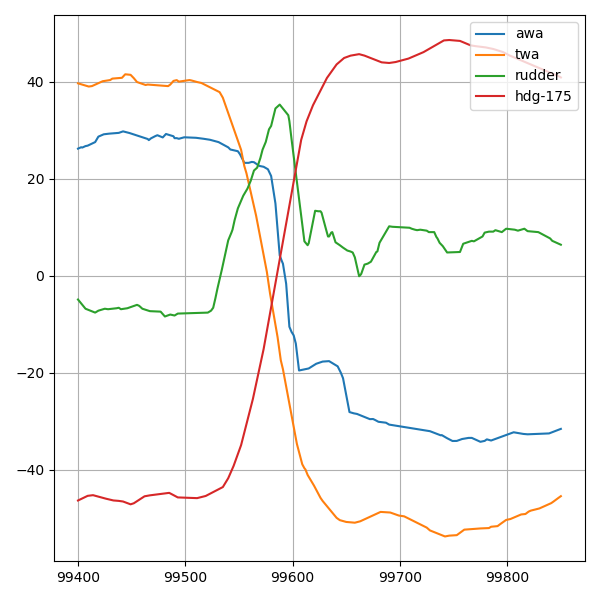

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [6]:
# Let's drill down into one tack and add additional signals to help understand what is going on.
narrow_slice = slice(99400, 99850)
wdf = df.loc[narrow_slice]

c.quick_plot(wdf.index, (wdf.awa, wdf.twa, wdf.rudder, wdf.hdg-175),   
            "awa twa rudder hdg-175".split())

# Note that TWA seems to be **leading** AWA!
# Note how TWA (from the boat) and HDG have very similar shapes (inverted)!

## TWA seems to lead AWA!!!

*Please take a moment to zoom and drill down into this data!*

We've added RUDDER and HDG to help identify the beginning of the tack (in a sense the tack cannot begin **before** the rudder is turned).  As we expect, after the rudder is turned the HDG responds almost immediately (less than a second).

- RUDDER turn begins at 99525 (though the turn is gradual...  as it should be)
- HDG responds by 99536

Notice that TWA (orange line) seems to **lead** AWA (blue line) by as much as 1-2 seconds.  *How could this be if TWA/TWD is computed from AWA??*  

Forget, for a moment, that this is a sailboat.  Imagine this is a wind sensor on a moving platform.  If you were to rotate the platform (and the wind sensor) toward the wind, then the AWA should decrease immediately (so would TWA).  

We will see that there are two potential reasons:

- Heel: the boat changes heel from tack to tack and this impacts the wind sensor.
- HDG: Assuming the boat estimates True Wind relative to the world, when the HDG changes (as measured by the compass) the TWA (which is measured relative to the boat) should rotate in the opposite direction.

## Heel and AWA

What is the effect of HEEL on AWA? For a constant heel the effect should be minimal.  But if the heel (aka roll) varies rapidly, **then masthead will move rapidly and that will introduce apparent wind.**  

As the boat rolls from one tack to another, the mast head **moves to windward**.  Motion to windward should increase the AWA.

We can investigate this by first smoothing heel (tthis time with a non-causal Butterworth), and then differentiating (to get roll rate). Finally we can multiply by the mast height to get the velocity at the mast head.

Note, this boat does **not** have a high quality, high frequency HEEL sensor.  Currently the external GPS has both a compass, and a roll/pitch sensor.  Roll is heel,  but it is only reported once a second (which may not be sufficient for this analysis).

<IPython.core.display.Javascript object>


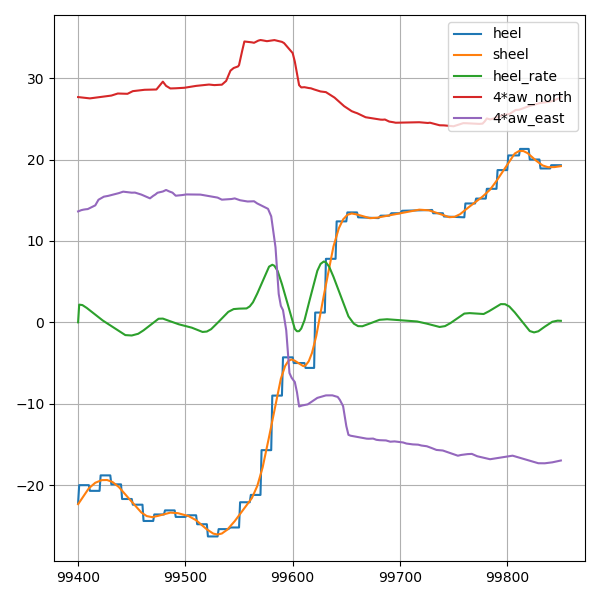

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [7]:
wdf = df.loc[narrow_slice]

# Compute a smoothed version of heel.  Note the cutoff is set to 0.3 Hz.  Since the signal is sampled at 1 Hz 
# Nyquist says we cannot hope measure any signal higher than 0.5 Hz.
coeff = p.butterworth_filter(cutoff=0.3, order=5)
# Note causal is false, which will filter the signal but not introduce any delay.
sheel = p.smooth_angle(coeff, wdf.zg100_roll, causal=False)

# Compute the degrees per second rate of change of heel
sample_rate = 10
heel_rate = sample_rate * np.diff(sheel, prepend=sheel[0])

aw_n = wdf.aws * np.cos(np.radians(wdf.awa))
aw_e = wdf.aws * np.sin(np.radians(wdf.awa))

c.quick_plot(wdf.index, (wdf.zg100_roll, sheel, heel_rate, 4*aw_n, 4*aw_e), 
            "heel sheel heel_rate 4*aw_north 4*aw_east".split())

## Roll and Wind Dynamics of a Tack

Focus first on AW_NORTH (the wind in the direction of travel), which increases as we begin the tack.  Since the boat is heavy, it will carry its speed as it turns up into the wind.  During the tack, as we head up into the wind AW_NORTH is the sum of TWS and SPD.

We can also see that AW_EAST drops,  but not until **after** AW_NORTH increases.  At some point the wind switches sides, from positive to negative.  But then there is a strange "bump artifact"; briefly it heads back toward positive.  This, I believe is because the mast begins to rotate to leeward, reducing wind speed.

Observed the double peak in the roll rate centered around the tack.  While this does not happen in every case it is not uncommon.  In a slow tack, as the boat passes head to wind there is a period where the heel is flat.

## Correcting Apparent Wind with Mast Velocity

In theory, we can correct the apparent wind velocity measured at the masthead, by computing the *heel induced* velocity of the mast head.  The rate of heel change times mast height is the velocity of mast head in the "boat east" direction.

<IPython.core.display.Javascript object>


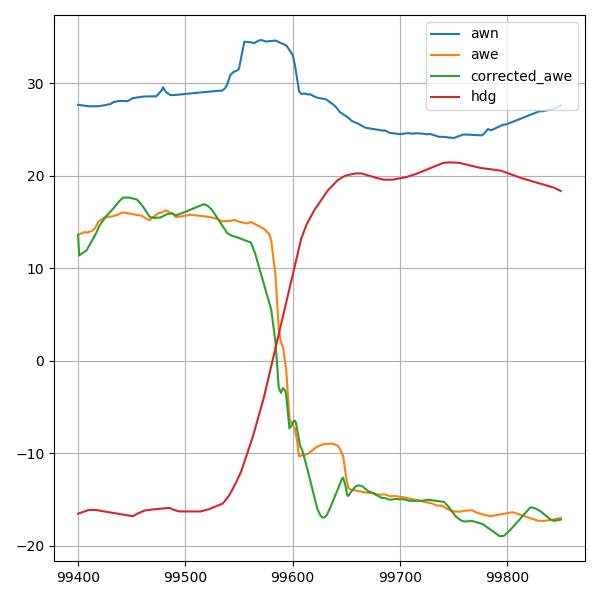

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [8]:
wdf = df.loc[narrow_slice]

# Convert to masthead velocity
feet_per_meters = 0.3048
mast_height = 50 * feet_per_meters
mast_vel = mast_height * np.radians(heel_rate)

# Corrected 
correction = mast_height * np.radians(heel_rate)
caw_e = aw_e - correction

c.quick_plot(wdf.index, (4*aw_n, 4*aw_e, 4*caw_e, 0.4*(wdf.hdg-170)), 
            "awn awe corrected_awe hdg".split())


### Corrected Apparent Wind responds more quickly

The corrected version of AW East responds **seconds** before AWA, and the odd bump is now missing.

<IPython.core.display.Javascript object>


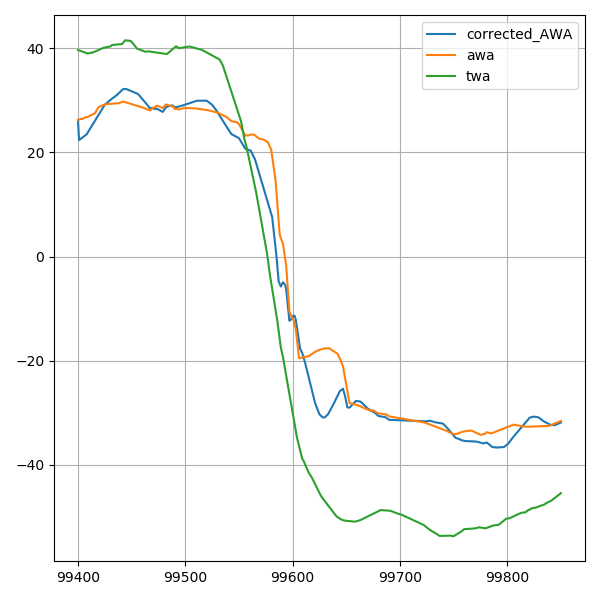

<IPython.core.display.Javascript object>


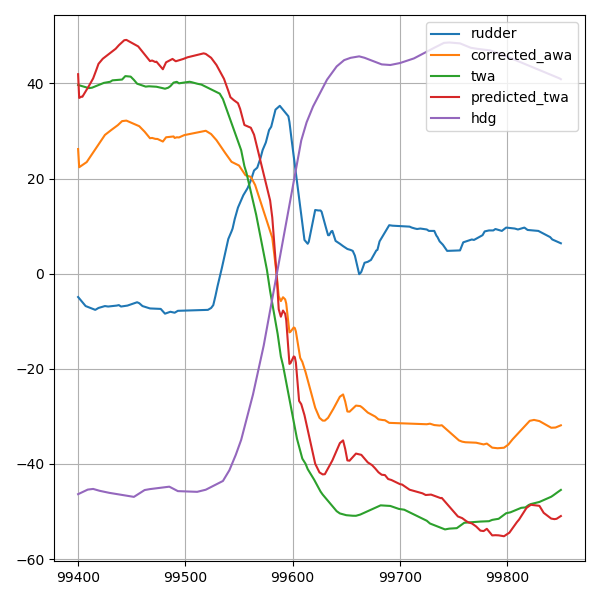

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [9]:
# Convert back to AWS and AWA
cawa = np.degrees(np.arctan2(caw_e, aw_n))
caws = np.sqrt(np.square(aw_n) + np.square(caw_e))


tw_north = p.cos_d(cawa) * caws - wdf.spd
tw_east = p.sin_d(cawa) * caws

predicted_twa = np.degrees(np.arctan2(tw_east, tw_north))

c.quick_plot(wdf.index, (cawa, wdf.awa, wdf.twa),
                        "corrected_AWA awa twa".split())

c.quick_plot(wdf.index, (wdf.rudder, cawa, wdf.twa, predicted_twa, wdf.hdg-175),   
            "rudder corrected_awa twa predicted_twa hdg".split())

The corrected AWA now **leads** smoothed AWA by over a second, and there is no weird bump at the end.

In [10]:
# Repeat for the entire signal

# Note, the pre-processing libraries computed two quantities: the "raw" corrected AWS/AWA and 
# a smoothed version.

# Use the smoothed version for now.
tw_north = p.cos_d(df.scawa) * df.scaws - df.spd
tw_east = p.sin_d(df.scawa) * df.scaws

df['predicted_twa'] = np.degrees(np.arctan2(tw_east, tw_north))

<IPython.core.display.Javascript object>


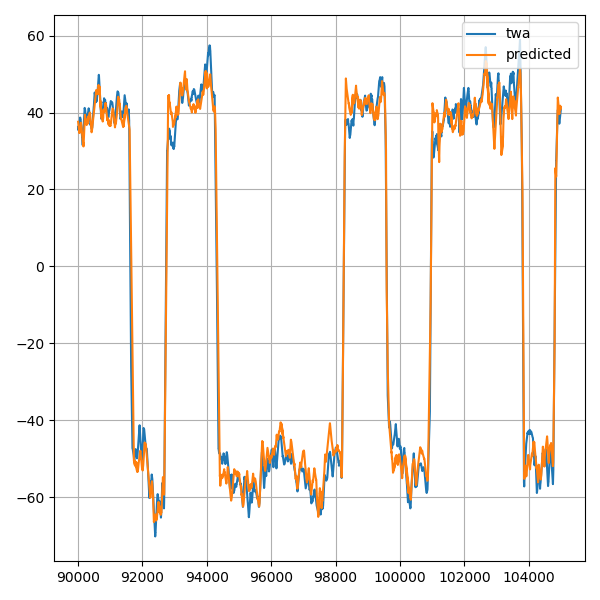

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [11]:
wdf = df.loc[tacks_slice]

c.quick_plot(wdf.index, (wdf.rtwa, wdf.predicted_twa), "twa predicted".split())

## Back to TWA/TWS

While we can clearly see that the fit is much better than before there are still some issues.

1. The fit to TWA is good on the coarse level, but does not fit in the details.
1. Boat TWA is both smoother and it still **leads** our predicted TWA.

(Both of these issues are subtle.)

Another observation is worth making. **Notice that TWA and HDG are near mirror images**.  Though it might be hard to see in this graph.  We can investigate this be trying to predict TWA from HDG alone. 

To do this we will find the best parameters `alpha` and `beta` such that 

`twa[t] = alpha hdg[t] + beta`

If they are mirror images then `alpha` is -1 and beta is the TWD.

In [12]:
def least_square_fit(target, signal):
    "Compute the least squares fit of target from signal."
    a = np.vstack((signal, np.ones((len(signal))))).T
    b = np.asarray(target)
    fit = np.linalg.lstsq(a, b, rcond=None)[0]
    predictions = a.dot(fit)
    return fit, predictions

<IPython.core.display.Javascript object>


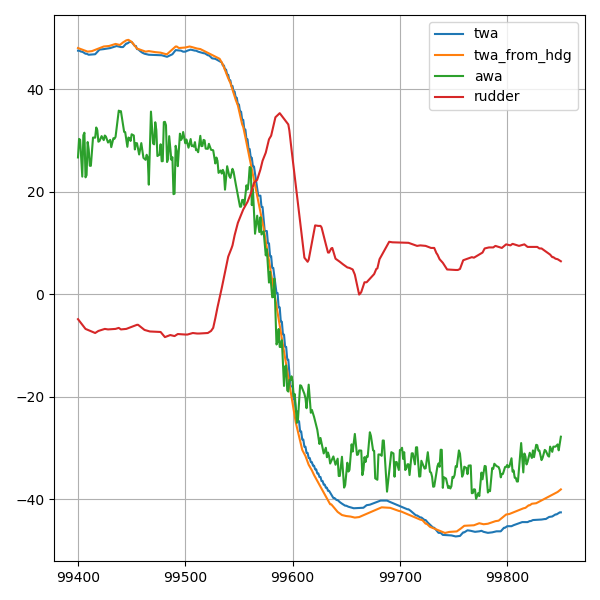

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [13]:
# Let's try to predict the TWA from HDG alone ?!?!!?
wdf = df.loc[narrow_slice]
# For a short time slice is TWA a linear function of HDG?
fit, pred = least_square_fit(wdf.rtwa, wdf.rhdg)

c.quick_plot(wdf.index, (wdf.rtwa, pred, wdf.cawa, wdf.rudder), "twa twa_from_hdg awa rudder".split())

In [14]:
print(f"Best fit for TWA is {fit[1]:.3f} {fit[0]:+.3f} * HDG")
abs_error = np.abs(wdf.rtwa - pred)
print(f"Average error is {np.mean(abs_error):.3f} degrees")

Best fit for TWA is 177.252 -1.000 * HDG
Average error is 1.438 degrees


### We can predict TWA from HDG alone? ... sort of.

Over a short period of time, the TWA is closely approximated by `TWA = 177 - HDG`, with an average error of about 1.4 degrees.

Both the average and graph and the graph show that the HDG and TWA are closely related (the blue and orange curves above).

Why is it possible to predict TWA from HDG alone?  It actually makes sense from a physical standpoint: if **TWA = (TWD - HDG)** and **TWD** is roughly constant over a short period of time (1000/10 = 100 seconds). During this period TWD must have been approximately 182 degrees.

The above framework for computing TWA/TWS is too simplistic.

Rather than estimate TWA/TWS, perhaps it is better to estimate TWD/TWS (true wind direction and speed).  TWD is a physical property of the **world**, and while it varies with time, it does not depend on the boat.  So for example, some boats tack a lot and others very rarely.  Some boat have great drivers that keep a consistant TWA and others vary a lot.  Estimating TWA requires a filtering process that can be robust to these differences.  TWD depends only on the physics of wind in the world.

TWA is then computed from TWD by subtracting HDG. And this explains why TWA can lead AWA. TWA will react immeadiately as HDG changes. 

The average absolute difference between TWD and TWA+HDG is 0.2527632432386612 degrees
The 99th percentile of the abs difference is 1.9735963846024265 degrees


<IPython.core.display.Javascript object>


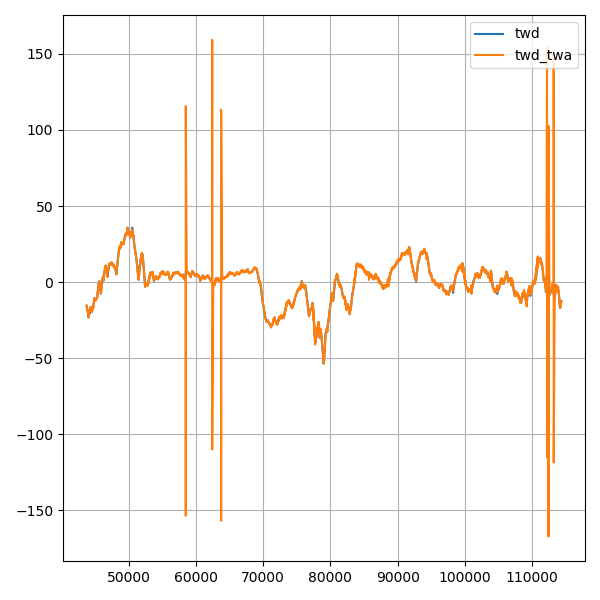

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [15]:
# Let's verify that TWD and TWA are directly related by HDG + variation
variation = df.variation.mean()
twd_from_twa = np.mod(df.rtwa + df.hdg + variation, 360)

abs_diff = np.abs(df.rtwd - twd_from_twa)

print(f"The average absolute difference between TWD and TWA+HDG is {abs_diff.mean()} degrees")
print(f"The 99th percentile of the abs difference is {np.percentile(abs_diff, 99)} degrees")

m = df.rtwd.mean()
c.quick_plot(df.index, (df.rtwd-m, twd_from_twa-m),
               "twd twd_twa".split())


### How to estimate TWD/TWS directly?

I started out considering a Kalman filter.  The classic Kalman filter would proceed by iterating two steps: propagate and update.

A Kalman filter works in reverse from our approach above: given the current estimate of TWD/TWS (and HDG and SPD) the Kalman filter predicts AWA, AWS (rather than computing TWD/TWS from AWA/AWS).  If the predictions are in error a Kalman filter updates TWD/TWS to reduce these errors.  This is known as the "update step".

The "propagate step" takes the current estimate and computes a new estimate.  This is the place to incorporate our sense of how fast wind direction may change in the world (it has nothing to do with boats!).

A fully probabilistic derivation of the Kalman filter also involves covariance matrices.

A simpler, though similar alternative, is an iterative filter, which starts with a guess at TWD/TWS.  For each new observation the algorithms performs the following steps:

1. Observe AWA, AWS, HDG, and SPD
1. Predict AWA and AWS from HDG, SPD and the current guess for TWD and TWS
1. Measure the error in this prediction.
1. Update TWD/TWS to reduce this error. 

The updates in the final step can be "large" ensuring that error are small, or the updates can be small.  By keeping the changes in the final step small the filter produces a smooth version of TWD/TWS.   

### Update equations

The goal is to determine how to update estimates for TWA and TWS given observations.  We will do this by taking the derivative of the observation equations.  These derivatives are used to update the estimates to reduce the residuals.

Short hand:

    twa = twd - (hdg + var)
    c   = cos(twa)
    s   = sin(twa)

These are the predicted observations, given the hidden state: TWD/TWS.

    predicted_aw_n = spd + c * tws
    predicted_aw_e =       s * tws

And these are the residuals (the difference between actual and predicted).

    r_n = (aw_n - predicted_aw_n)
    r_e = (aw_e - predicted_aw_e)
    
And below are the derivates of aw_n and aw_e with respect to tws and twd (in that order).
    
    d_aw_n = [    c,   tws * -s]
    d_aw_e = [    s,   tws *  c]
    
Given residuals, we can update the parameters using the derivatives of the predictions

    delta_tws = r_n * c         + r_e * s
    delta_twa = r_n * tws * -s  + r_e * tws * c

Sure...  that is the math,  but what is the intuition?  Take one half of one term:

    delta_tws = r_n * c
              = (aw_n - predicted_aw_n) * cos(twa)
    
It says that if aw_n is greater than the predicted, then increase tws if twa is less than 90, and decrease if it greater than 90.

    delta_twa = r_n * tws * -s
              = (aw_n - predicted_aw_n) * tws * -1 * sin(twa)
              
This says that if aw_n is greater than predicted, then decrease twa.

**Note**, these are directions of update tws and twd over time.  The rate of change is proportional to an adaptation rate $\epsilon$.  Small values for $\epsilon$ will lead to small and gradual changes in twd/tws: smoother estimates but larger residuals.  Small values introduce smoothing/damping/filtering. 


In [16]:
@jit(nopython=True)
def estimate_true_wind_helper(epsilon, aws, awa, hdg, spd, tws, twd, variation, tws_mult):
    twd = np.radians(twd) + np.zeros(awa.shape)
    tws = tws + np.zeros(awa.shape)
    res_n = np.zeros(awa.shape)
    res_e = np.zeros(awa.shape)
    aw_n = aws * np.cos(np.radians(awa))
    aw_e = aws * np.sin(np.radians(awa))

    rhdg = np.radians(hdg)
    variation = np.radians(variation)

    for i in range(1, len(aws)):
        # Compute residuals from the prediction and observation
        twa = twd[i-1] - (rhdg[i] + variation)  # Boat relative angle.
        c = np.cos(twa)
        s = np.sin(twa)
        # The forward predictions
        f_aw_n = spd[i] + c * tws[i-1]
        f_aw_e =          s * tws[i-1]

        # Residuals
        res_n[i] = (aw_n[i] - f_aw_n)
        res_e[i] = (aw_e[i] - f_aw_e)

        # derivatives
        delta_tws = res_n[i] * c + res_e[i] * s
        delta_twd = res_n[i] * tws[i-1] * -s + res_e[i] * tws[i-1] * c

        # Hack, which the update to TWS and TWD don't have the same magnitude
        tws[i] = epsilon * tws_mult * delta_tws + tws[i-1]
        twd[i] = epsilon * delta_twd + twd[i-1]

    return np.degrees(twd), tws, res_n, res_e

def estimate_true_wind(epsilon, df, awa_mult=1.0, aws_mult=1.0, spd_mult=1.0, awa_offset=0, tws_mult=30):
    return estimate_true_wind_helper(epsilon,
                                     aws = aws_mult * np.asarray(df.raws),
                                     awa = awa_mult * np.asarray(df.rawa) + awa_offset,
                                     hdg = np.asarray(df.rhdg),
                                     spd = spd_mult * np.asarray(df.rspd),
                                     tws = df.tws.iloc[0],
                                     twd = df.twd.iloc[0],
                                     variation = df.variation.mean(),
                                     tws_mult = tws_mult
                                    )

2.9135388305787857
1.1525518113999487
0.0506012993232319


<IPython.core.display.Javascript object>


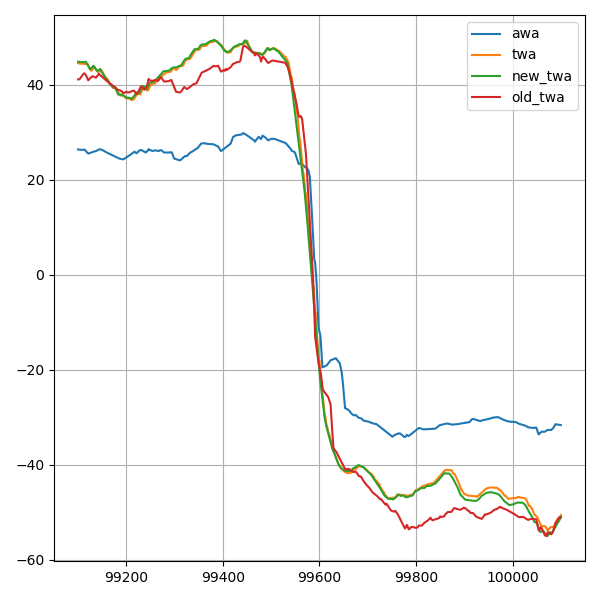

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [18]:
# Sorry about these magic numbers...  more below
param = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
                  awa_offset=0, tws_mult=16, epsilon=0.0002)

variation = df.variation.mean()

if True:
    (twd, tws, res_n, res_e) = estimate_true_wind(**param)
    df['ptwd'] = twd
    df['ptwa'] = twd - (df.rhdg + variation)
    df['ptws'] = tws

wdf = df.loc[tacks_slice]    
wdf = df
print((wdf.rtwa - wdf.ptwa).abs().mean())
print((wdf.rtwd - wdf.ptwd).abs().mean())
print((wdf.rtws - wdf.ptws).abs().mean())

wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.awa, wdf.rtwa, wdf.ptwa, wdf.predicted_twa),   
            "awa twa new_twa old_twa".split())

<IPython.core.display.Javascript object>


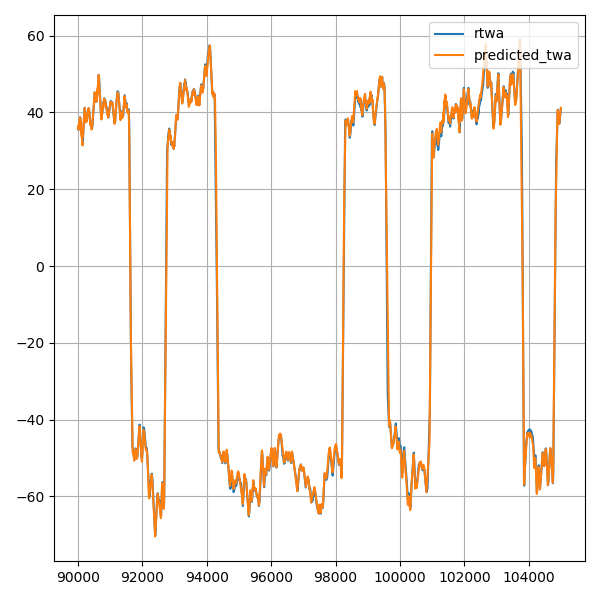

<IPython.core.display.Javascript object>


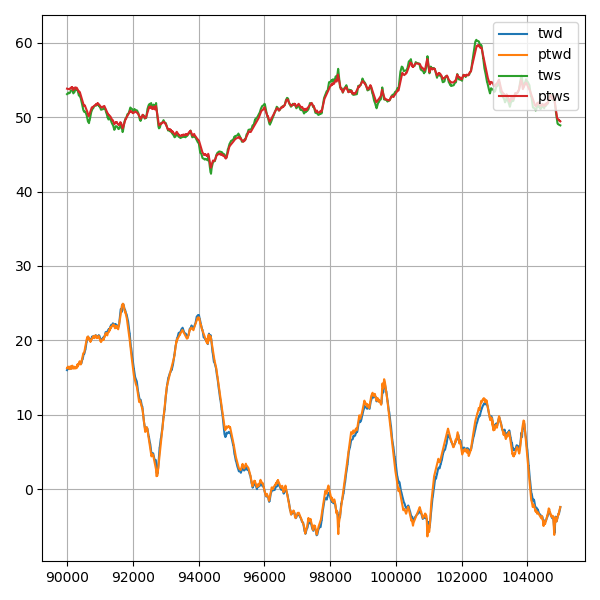

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [19]:
wdf = df.loc[tacks_slice]

c.quick_plot(wdf.index, (wdf.rtwa, wdf.ptwa), "rtwa predicted_twa".split())

c.quick_plot(wdf.index, (wdf.rtwd-180, wdf.ptwd-180, 10*wdf.rtws, 10*wdf.ptws),
                 "twd ptwd tws ptws awa".split())

## Near Perfect Match

**I was astonished at the quality of this fit.**  It is much better than the similar figure above!

1. The shape and details are almost everywhere identical, down to the finest details.
1. The areas where the match is not perfect corresponds to areas with very low TWS (2 knots).  This is to be expected, because wind direction is hard to measure when the wind speed is low.

From this I conclude that we almost certainly have the correct algorithm.  And that includes the flaws that we will investigate below.  (... why would we want an algorithm with flaws?  Becuase only be understanding the algorithm can we fix the flaws ...)

### Optimization to find the best parameters

Note, the magic numbers above can be automatically estimated from optimization code below.

The approach is simple, search for the set of parameters that yield TWD/TWS estimates that best fit those computed on the boat.

In [20]:
from scipy.optimize import minimize

wdf = df.loc[tacks_slice]

# Returns a score base on the fit between our predicted TWS/TWD and the logged quantities.
def fit(m):
    (twd, tws, res_n, res_e) = estimate_true_wind(m[5], df, m[0], m[1], m[2], m[3], m[4])    
    df['ptwd'] = twd
    df['ptwa'] = twd - (df.rhdg + variation)
    df['ptws'] = tws

    wdf = df
    ctwa = 0.2 * (wdf.rtwa - wdf.ptwa).abs().sum()
    ctwd = 1 * (wdf.rtwd - wdf.ptwd).abs().sum()
    ctws = 1 * (wdf.rtws - wdf.ptws).abs().sum()
    return ctwa + ctwd + ctws

# Initial conditions
m0 = np.array([1.0, 1.0, 1.0, 0.0, 15, 0.0003])

# Note this can take up to a minute.
res = minimize(fit, m0, method='nelder-mead',
               options={'xatol': 1e-5, 'disp': True})

print(res.x)

[ 0.9998  1.0019  1.1015 -0.0221 15.3072  0.0003]


## Summary

We have proposed a single stage, error driven, filtering algorithm for estimating TWD/TWS directly, and from this computing TWA.  

This is unlike the initial approach investigated, where TWA/TWS was computed from AWA/AWS/SPD.

This new approach processes the raw measurements directly (without smoothing).  The filtering of output is determined by epsilon.  There is no separate "filtering/smoothing" step.  

The result is a near perfect fit to the quantities estimated on the boat!

**Are we done?**  Sadly no... 

### These estimates have significant flaws!

While this explains the mystery of TW on the boat, **the estimates are almost certainly wrong**!

Below let's drill down to some tacks.

<IPython.core.display.Javascript object>


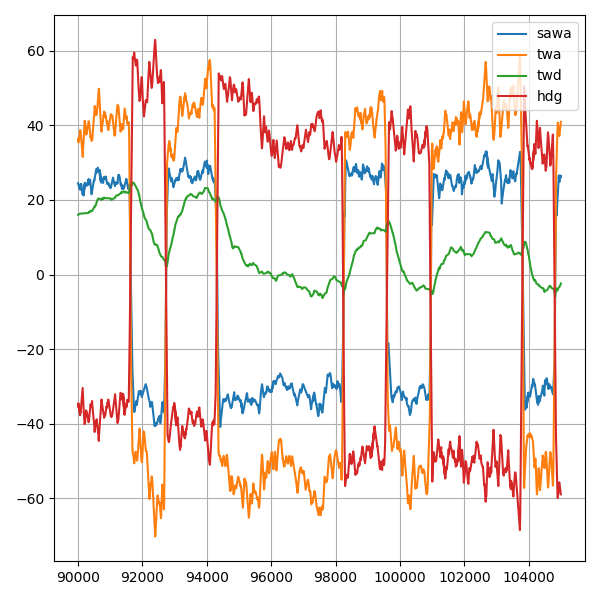

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [21]:
wdf = df.loc[tacks_slice]    

c.quick_plot(wdf.index, (wdf.awa, wdf.rtwa, wdf.rtwd-180, wdf.rhdg-180),
                 "sawa twa twd hdg".split())

## Tacks seem to have a radical impact on TWD

Notice how changes in TWD seems to be tightly coupled to the tacks.  Every tack leads to a immediate change in TWD, which eventually converges to as much as 15 degrees (in 30-50 seconds). Note, I briefly considered the possibility that the tacks were in response to these changes.  But the reality is that the TWD changes **after** the tack and never before.

**These tack related changes are artifacts.**  The true wind should not depend on the tack, or be affected by a tack.

A simple approach to remove these "hitches" is to smooth out TWD (by decreasing epsilon). 

- The shifts are long time scale phenomena, sometimes taking 50-100 seconds.  The increase in "smoothing" would need to be radical.
- This might be acceptable if the TWD is not varying much,  but it would miss (smooth out) changes that are likely important. 

<IPython.core.display.Javascript object>


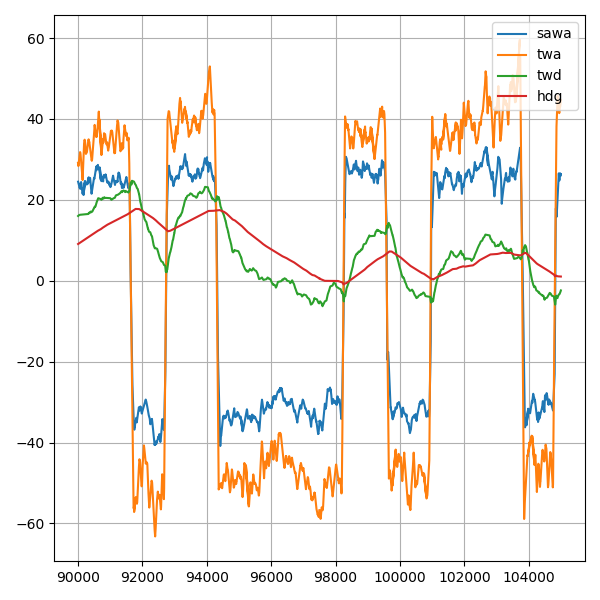

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [23]:
# Let's try reduce epsilon a lot.
reduce = 0.1
m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
              awa_offset=0, tws_mult=reduce*16.109, epsilon=reduce*0.0003)

(twd, tws, res_n, res_e) = estimate_true_wind(**m)
    
df['ptwd'] = twd
df['ptwa'] = twd - (df.rhdg + variation)
df['ptws'] = tws

wdf = df.loc[tacks_slice]    

c.quick_plot(wdf.index, (wdf.awa, wdf.ptwa, wdf.rtwd-180, wdf.ptwd-180),
                 "sawa twa twd hdg".split())

### Smoother, but still wrong!

**While TWD is much smoother, there are still issues:**

1. There is a significant hitch associated with each tack.
2. This smoothing will eliminate true rapid changes in TWD.

### Using Heel Corrected AWA/AWS

Perhaps this artifact can be corrected by using the improved estimates of AWA (using HEEL)?

<IPython.core.display.Javascript object>


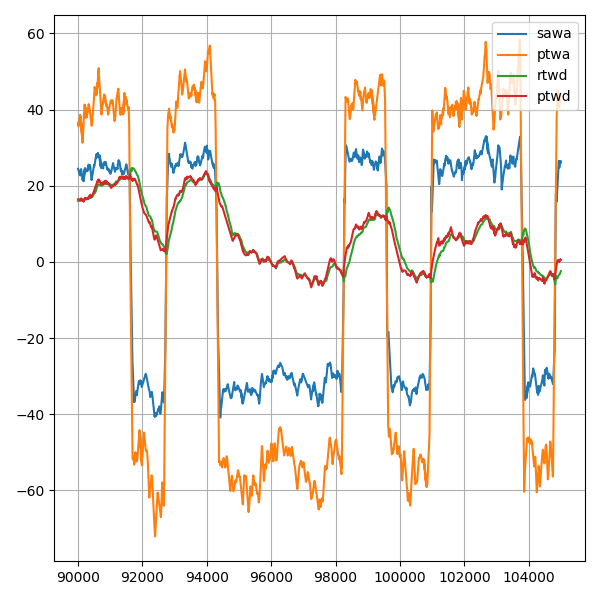

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [24]:
reduce = 0.1
m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
              awa_offset=0, tws_mult=reduce*16.109, epsilon=reduce*0.003)

# Note, we are using CAWS and CAWA below
(twd, tws, res_n, res_e) = estimate_true_wind_helper(
    m.epsilon,
    # Note, we are now using corrected AWS and AWA
    aws = m.aws_mult * np.asarray(df.caws),
    awa = m.awa_mult * np.asarray(df.cawa) + m.awa_offset,
    hdg = np.asarray(df.rhdg),
    spd = m.spd_mult * np.asarray(df.rspd),
    tws = df.tws.iloc[0],
    twd = df.twd.iloc[0],
    variation = df.variation.mean(),
    tws_mult = m.tws_mult
)

df['ptwd'] = twd
df['ptwa'] = twd - (df.rhdg + variation)
df['ptws'] = tws

wdf = df.loc[tacks_slice]    

c.quick_plot(wdf.index, (wdf.awa, wdf.ptwa, wdf.rtwd-180, wdf.ptwd-180),
                 "sawa ptwa rtwd ptwd".split())

Correcting AWA/AWS for heel does not seem to help much.  That makes sense, because the heel induced error in AWA only arises **during** a tack, for at most 10 seconds.


## Is the problem current or leeway?

The simple scheme for relating apparent wind (AW) and true wind (TW) assumes that the motion of the boat is simple: the boat moves in the direction of HDG at SPD.  There are two other sources of motion which could violate this assumption: current and leeway.

Current is the flow of water most often related to tides (particularly in the Puget Sound).  The true motion of the boat is the **sum** of the boat's sailing vector and the current vector.  It is not impossible to be sailing in light winds, and actually find you are moving backward.  Often current tables are available that can be use to predict current (and many experienced sailors have excellent memories based on past racing).

While current is an external phenomena unrelated to the boat, **leeway** is the tendency of boat to slip to leeward as it sails upwind. Naively, one might imagine that the boat sails in the direction it is pointed.  In practice the boat is likely slipping 2-10 degrees lower than the HDG, and this is called leeway.

As the apparent wind passes over the sail, the lift/force generated can be decomposed into two components: one in the direction of boat travel (drive), and a second perpendicular to travel (heel).  The drive force keeps the boat moving; the heel pushes sideways and causes heel (no surprise) and also a drift to leeward.  Upwind sailing is possible because as the boat begins to move the keel generates lift to counteract the heel force.  Since the keel is a symmetric wing, it must have a positive angle of attack (point up) to generate lift and counteract the heeling force.  In this way, the COG is alway lower than HDG, and the angle is the leeway.  

I consider leeway an internal property, since it is possible to measure leeway in various conditions and use this as a boat specific correction (higher heel angles typically lead to larger leeway angles).

So there are really two intuitions:
- Since the sail lift has a component to leeward there must be some drift to leeward.
- Since the keel must counteract the leeward force, it must point slightly higher than the COG.

Both current and leeway cause the boat to move differently than predicted by the simple "speed times heading" model.

Intuitively,  if the boat is slipping to leeward (which is away from the wind) then the measured AWA would be decreased.  So for a given AWA the estimated TWS should be a bit larger with leeway.  

### How to correct for these motions?

GPS can be used to measure true boat motion using COG and SOG.  This combined with HDG, provides a means to related AW and TW.  

### COG/SOG are delayed

A quick aside.  As we learned in the notebook on [Instrument Delays](Instrument_Delays.ipynb), COG/SOG are delays with respect to other signals on the boat.  We can address this delay by "looking ahead" to used later measurements when computing.  Since we have all the data together from the log, this is easy (just use later entries in the log).  This can be done online as well (while sailing) by delaying the TWD/TWS calculation.


<IPython.core.display.Javascript object>


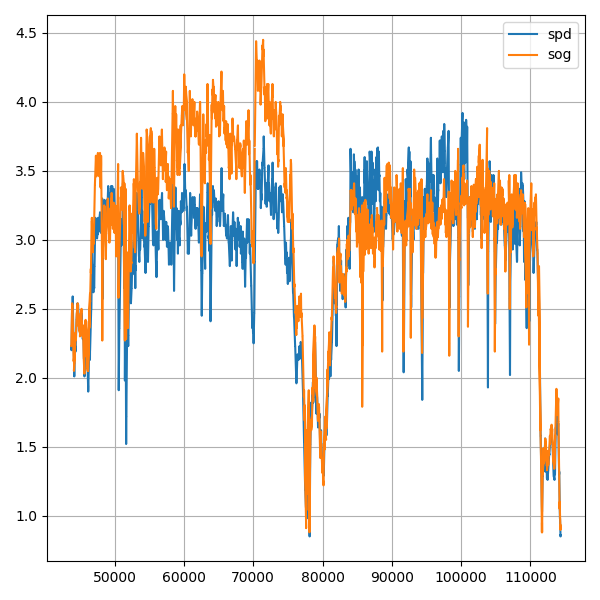

<IPython.core.display.Javascript object>


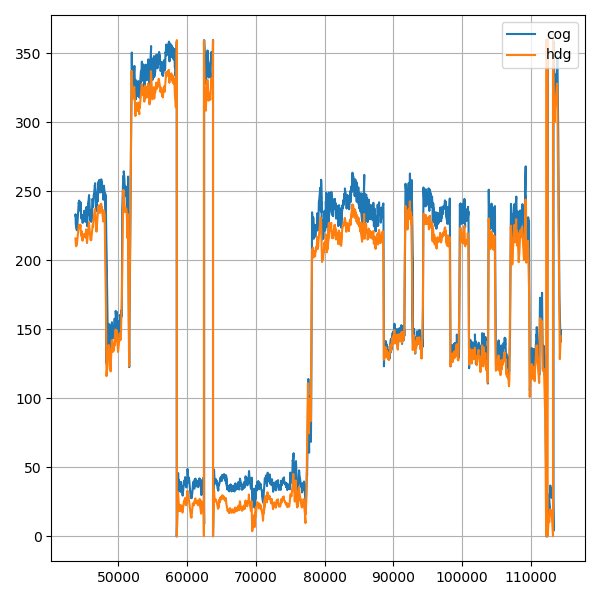

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [26]:
# Let's take a quick glance at SPD vs. SOG and HDG vs. COG.
wdf = df
c.quick_plot(wdf.index, (wdf.rspd, wdf.rsog), "spd sog".split())
c.quick_plot(wdf.index, (wdf.rcog, wdf.rhdg), "cog hdg".split())

### Modifying the filter

The required changes to the filter are minimal. 

Once again, we move everything to boat coordinates (with boat north pointing to the bow).  In the new calculation, the boats speed is SOG, but the course is not necessarily zero degrees.  Instead the course is `COG - (HDG - variation)`  (e.g. if the true heading was equal to COG then the course would be zero).  But more typically the COG is not along the direction of HDG.  COG causes the boat to slip away from the wind; on port tack the COG is larger than HDG (the boat slips to starboard) and on starboard tack COG is smaller than HDG (the boat slips to port). Current can have an arbitrary affect on COG vs. HDG.

Since COG, SOG, and HDG are sensors, they are constants W.R.T. so the updated equations remain the same.

In [27]:
@jit(nopython=True)
def estimate_true_wind_helper_leeway(epsilon, aws, awa, hdg, spd, cog, sog, 
                                     tws_init, twd_init, variation, tws_mult, shift):
    # TWD/TWS are ouptputs.  This sets the initial conditions.
    twd = np.radians(twd_init) + np.zeros(awa.shape)
    tws = tws_init + np.zeros(awa.shape)
    # Residuals are stored here.
    res_n = np.zeros(awa.shape)
    res_e = np.zeros(awa.shape)
    deps = np.zeros(awa.shape)
    # Process apparent wind to decompose into boat relative components.
    aw_n = aws * np.cos(np.radians(awa))
    aw_e = aws * np.sin(np.radians(awa))

    # preconvert some values
    rhdg = np.radians(hdg)
    rcog = np.radians(cog)
    variation = np.radians(variation)
    
    eps = epsilon
    for i in range(1, len(aws)-shift):
        # Transform to boat relative angles.
        twa = twd[i-1] - (rhdg[i] + variation)
        course_angle = rcog[i+shift]  - (rhdg[i] + variation)
        
        # Useful below
        c = np.cos(twa)
        s = np.sin(twa)
        
        # Boat relative vector of true wind
        twn = c * tws[i-1]
        twe = s * tws[i-1]
        
        # Boat relative vector of travel
        btn = np.cos(course_angle) * sog[i+shift]
        bte = np.sin(course_angle) * sog[i+shift]
        
        # The forward predictions, introduce leeway
        f_aw_n = twn + btn
        f_aw_e = twe - bte  ## WHY IS THIS NEGATIVE???  SEEMS INCORRECT

        # Residuals
        res_n[i] = (aw_n[i] - f_aw_n)
        res_e[i] = (aw_e[i] - f_aw_e)

        # derivatives
        delta_tws = res_n[i] * c + res_e[i] * s
        delta_twd = res_n[i] * tws[i-1] * -s + res_e[i] * tws[i-1] * c
        
        # Hack, which the update to TWS and TWD don't have the same magnitude
        tws[i] = eps * tws_mult * delta_tws + tws[i-1]
        twd[i] = eps * delta_twd + twd[i-1]
        
        if (np.abs(res_n[i]) + np.abs(res_e[i])) > 1.5:
            eps = min(1.05 * eps, 10*epsilon)
        else:
            eps = (eps + epsilon) / 2
        deps[i] = eps

    return np.degrees(twd), tws, res_n, res_e, deps


<IPython.core.display.Javascript object>


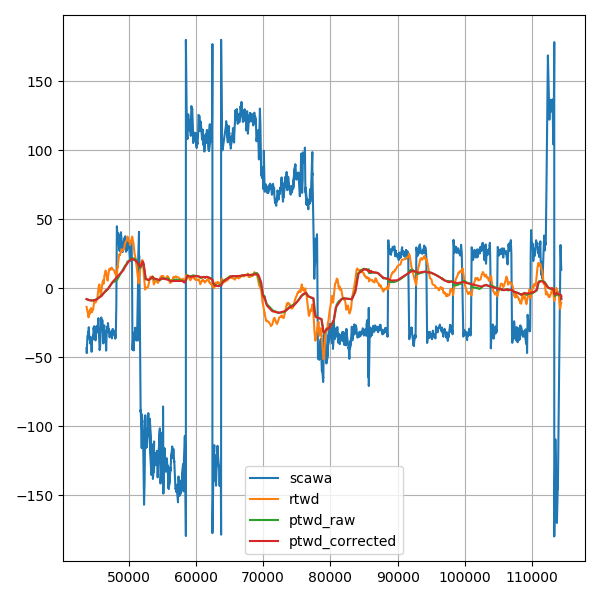

In [27]:
reduce = 0.1
m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
              awa_offset=0, tws_mult=16, epsilon=reduce*0.0003)

ss = tacks_slice
ss = slice(df.index[0], df.index[-1])
wdf = df.loc[ss]

delay_guess = 12

c.quick_plot(wdf.index, (wdf.scawa, wdf.rtwd-180))

if True:
    (twd, tws, res_n, res_e, deps) = estimate_true_wind_helper_leeway(
    m.epsilon,
    # Using Raw AWA and AWS
    aws = m.aws_mult * np.asarray(df.raws),
    awa = m.awa_mult * np.asarray(df.rawa) + m.awa_offset,
    hdg = np.asarray(df.rhdg),
    spd = m.spd_mult * np.asarray(df.rspd),
    cog = np.asarray(df.rcog),
    sog = np.asarray(df.rsog),
    tws_init = df.tws.iloc[0],
    twd_init = df.twd.iloc[0],
    variation = df.variation.mean(),
    tws_mult = m.tws_mult,
    shift = delay_guess
    )
    df['ptwd1'] = twd
    wdf = df.loc[ss]
    plt.plot(wdf.index, wdf.ptwd1-180)

m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.0, 
              awa_offset=0, tws_mult=16, epsilon=reduce*0.0003)
if True:
    (twd, tws, res_n, res_e, deps) = estimate_true_wind_helper_leeway(
    m.epsilon,
    # Using heel corrected AWS and AWA
    aws = m.aws_mult * np.asarray(df.caws),
    awa = m.awa_mult * np.asarray(df.cawa) + m.awa_offset,
    hdg = np.asarray(df.rhdg),
    spd = m.spd_mult * np.asarray(df.rspd),
    cog = np.asarray(df.rcog),
    sog = np.asarray(df.rsog),
    tws_init = df.tws.iloc[0],
    twd_init = df.twd.iloc[0],
    variation = df.variation.mean(),
    tws_mult = m.tws_mult,
    shift = delay_guess
    )
    df['ptwd2'] = twd
    wdf = df.loc[ss]
    plt.plot(wdf.index, wdf.ptwd2-180)

plt.legend("scawa rtwd".split() + "ptwd_raw ptwd_corrected".split())


In [1]:
plt.figure()
plt.plot(deps)

NameError: name 'plt' is not defined

In [ ]:
ss = slice(df.index[0], df.index[-1])
ss

### Massively better!

- The red and green curves show the new results, using SOG/COG.  
   - Red shows the results using heel corrected AWA/AWS.
- Yellow shows the previous results, with the tack related artifacts.

This change to COG/SOG has almost eliminated the tendency of tacks to affect TWD.

Note, while we can estimate (or guess) the correct delay, it can be evaluated as well. Below we try multiple delays and plot the results.

In [ ]:
reduce = 1.0
m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
              awa_offset=0, tws_mult=reduce*16, epsilon=reduce*0.0003)

ss = tacks_slice
wdf = df.loc[ss]
c.quick_plot(wdf.index, (wdf.scawa, wdf.rtwd-180))

rrr = [4, 12, 20]
for i in rrr:
    # Note, we are using CAWS and CAWA below
    (twd, tws, res_n, res_e) = estimate_true_wind_helper_leeway(
    m.epsilon,
    aws = m.aws_mult * np.asarray(df.caws),
    awa = m.awa_mult * np.asarray(df.cawa) + m.awa_offset,
    hdg = np.asarray(df.rhdg),
    spd = m.spd_mult * np.asarray(df.rspd),
    cog = np.asarray(df.rcog),
    sog = np.asarray(df.rsog),
    tws_init = df.tws.iloc[0],
    twd_init = df.twd.iloc[0],
    variation = df.variation.mean(),
    tws_mult = m.tws_mult,
    shift = i
    )
    df['ptwd'] = twd
    wdf = df.loc[ss]
    plt.plot(wdf.index, wdf.ptwd-180)

plt.legend("scawa rtwd".split() + ["delay_"+str(i) for i in rrr])



## Trying to get better, and failing!

Note, the rest of this notebook is less than optional.  It documents an attempt to get a more stable estimate of TWD in light wind.  As we saw in [Boat Instruments](Boat_Instruments.ipynb), direct processing of angles can be tricky.  It can often work better if you parameterize as a north/east vector (rather than angle and magnitude).

I failed to get this to work.  And it revealed a confusion I have about the sign of the COG/SOG correction above.  Though everything above seems to work well.

I wrote the code below as an alternative.  Note, TWD/TWS are now replaced by TW_N and TW_E (the vector rather than the angle).

I feel there are likely several bugs in this code.

In [ ]:
@jit(nopython=True)
def estimate_true_wind_helper_leeway_ne(epsilon, aws, awa, hdg, spd, cog, sog, 
                                     tws_init, twd_init, variation, shift):
    # Components of True Wind, initialized.
    tw_n = np.cos(np.radians(twd_init)) * tws_init + np.zeros(awa.shape)
    tw_e = np.sin(np.radians(twd_init)) * tws_init + np.zeros(awa.shape)
    
    # Residuals are stored here.
    res_n = np.zeros(awa.shape)
    res_e = np.zeros(awa.shape)
    # Pre-process apparent wind to decompose into boat relative components.
    aw_n = aws * np.cos(np.radians(awa))
    aw_e = aws * np.sin(np.radians(awa))

    # preconvert some values
    rhdg = np.radians(hdg + variation)
    rcog = np.radians(cog)

    eps = epsilon
    for i in range(1, len(aws)-shift):
        # Useful below
        c = np.cos(rhdg[i])
        s = np.sin(rhdg[i])

        # True wind rotated into boat coordinates
        tw_bn =  c * tw_n[i-i] + s * tw_e[i-1]
        tw_be =  -s * tw_n[i-i] + c * tw_e[i-1]
        course_angle = rcog[i+shift]  - rhdg[i]

        cc = np.cos(course_angle)
        sc = np.sin(course_angle)
        # Boat relative vector of travel
        btn = cc * sog[i+shift]
        bte = sc * sog[i+shift]
        
        # The forward predictions, introduce leeway
        f_aw_n = tw_bn + btn
        f_aw_e = tw_be + bte

        # Residuals
        res_n[i] = (aw_n[i] - f_aw_n)
        res_e[i] = (aw_e[i] - f_aw_e)

        # derivatives
        delta_tw_n = res_n[i] * c + res_e[i] * s
        delta_tw_e = res_n[i] * -s + res_e[i] * c
        
        tw_n[i] = eps * delta_tw_n + tw_n[i-1]
        tw_e[i] = eps * delta_tw_e + tw_e[i-1]

    return tw_n, tw_e, res_n, res_e

## Bugs? Write a simulator

One of the better ways to find bugs is to create a controlled dataset where the correct answer is known.

Note the data generated below is *really boring*.

In [ ]:
def make_signal(len, scale, offset):
    "Make a smooth random signal.  Not great,  but it works OK."
    coeff = p.butterworth_filter(cutoff=0.1, order=5)
    twd = np.random.randn((len))
    twd[0] = 0
    twd = scale * p.smooth(coeff, twd, causal=True)
    return twd + offset

# Construct a random "sailing" session
signal_length = 1000
variation = df.variation.mean()

# Create the "true values" of signals
twd = p.compass_angle(make_signal(signal_length, 20, 220))
hdg = p.compass_angle(make_signal(signal_length, 20, 180 - variation))

# Angle of the current.  aka SET
cur_ang = p.compass_angle(make_signal(signal_length, 10, -90))
# Speed of the current, aka DRIFT
cur_spd = 1 * make_signal(signal_length, 1, 1)

tws = make_signal(signal_length, 1, 5)
spd = make_signal(signal_length, 1, 3)

# From these the measured quantities can be computed.

# Now compute apparent wind, etc.  All below vectors are relative to TRUE NORTH (not boat north)
tw_n = tws * np.cos(np.radians(twd))
tw_e = tws * np.sin(np.radians(twd))

# Current vector
cur_n = cur_spd * np.cos(np.radians(cur_ang))
cur_e = cur_spd * np.sin(np.radians(cur_ang))

# Boat velocity vector.  Sum of boat speed and current.  Not necessarily aligned with hdg!
b_n = spd * np.cos(np.radians(hdg+variation)) + cur_n
b_e = spd * np.sin(np.radians(hdg+variation)) + cur_e

# COG and SOG, typically measured with GPS
cog = p.compass_angle(np.degrees(np.arctan2(b_e, b_n)))
sog = np.sqrt(np.square(b_e) + np.square(b_n))

# Apparent wind in TRUE NORTH (not relative to boat!!)
aw_tn = tw_n + b_n
aw_te = tw_e + b_e

# Apparent wind angle, relative to true north.
awa_tn = np.degrees(np.arctan2(aw_te, aw_tn))
aws = np.sqrt(np.square(aw_te) + np.square(aw_tn))

# AWA relative to the boat (this is the standard AWA).
awa = p.sign_angle(awa_tn - (hdg + variation))

In [ ]:
# Let's check that the simulated data is self consistent.  This also foreshadows the estimation filter.
aw_n = aws * np.cos(np.radians(awa))
aw_e = aws * np.sin(np.radians(awa))

rhdg = np.radians(hdg + variation)
rcog = np.radians(cog)

ch = np.cos(rhdg)
sh = np.sin(rhdg)

# True wind rotated into boat coordinates
tw_bn =  ch * tw_n + sh * tw_e
tw_be = -sh * tw_n + ch * tw_e

# Check this is the same as the conventional calculation.
print(np.abs(tw_bn - tws * np.cos(np.radians(twd - (hdg + variation)))).sum())
print(np.abs(tw_be - tws * np.sin(np.radians(twd - (hdg + variation)))).sum())

# Boat's direction of travel (in boat coordinates)
course_angle = rcog - rhdg # angle relative to boat
cc = np.cos(course_angle)
sc = np.sin(course_angle)

# Motion of the boat
btn = cc * sog
bte = sc * sog

f_aw_n = tw_bn + btn
f_aw_e = tw_be + bte

print(np.abs(f_aw_e - aw_e).sum())
print(np.abs(f_aw_n - aw_n).sum())

c.quick_plot(None, (twd, hdg+variation, cur_ang, cog), "(twd, thdg, cur_ang, cog)".split())
c.quick_plot(None, (tws, spd, cur_spd), "(tws, spd, cur_spd)".split())

### Now for the weirdness

The old code, which we know works on real data, **does not work on this simulated data!**

It does not work unless we flip the sign of the side slip correction.

In [ ]:
(ptwd, ptws, res_n, res_e) = estimate_true_wind_helper_leeway(
    0.01, aws, awa, hdg, spd, cog, sog, tws[0], twd[0], variation, 16.0, 0)

print(np.abs(ptwd - twd).sum())
print(np.abs(ptws - tws).sum())
c.quick_plot(None, (ptwd, twd, 40*ptws, 40*tws), "ptwd, twd, 40*ptws, 40*tws".split())

In [ ]:
@jit(nopython=True)
def estimate_true_wind_helper_leeway_flip(epsilon, aws, awa, hdg, spd, cog, sog, 
                                     tws_init, twd_init, variation, tws_mult, shift):
    # TWD/TWS are ouptputs.  This sets the initial conditions.
    twd = np.radians(twd_init) + np.zeros(awa.shape)
    tws = tws_init + np.zeros(awa.shape)
    # Residuals are stored here.
    res_n = np.zeros(awa.shape)
    res_e = np.zeros(awa.shape)
    # Process apparent wind to decompose into boat relative components.
    aw_n = aws * np.cos(np.radians(awa))
    aw_e = aws * np.sin(np.radians(awa))

    # preconvert some values
    rhdg = np.radians(hdg)
    rcog = np.radians(cog)
    variation = np.radians(variation)
    
    eps = epsilon
    for i in range(1, len(aws)-shift):
        # Transform to boat relative angles.
        twa = twd[i-1] - (rhdg[i] + variation)
        course_angle = rcog[i+shift]  - (rhdg[i] + variation)
        
        # Useful below
        c = np.cos(twa)
        s = np.sin(twa)
        
        # Boat relative vector of true wind
        twn = c * tws[i-1]
        twe = s * tws[i-1]
        
        # Boat relative vector of travel
        btn = np.cos(course_angle) * sog[i+shift]
        bte = np.sin(course_angle) * sog[i+shift]
        
        # The forward predictions, introduce leeway
        f_aw_n = twn + btn
        f_aw_e = twe + bte ## FLIPPING TO POSITIVE, THIS SEEMS CORRECT!!!

        # Residuals
        res_n[i] = (aw_n[i] - f_aw_n)
        res_e[i] = (aw_e[i] - f_aw_e)

        # derivatives
        delta_tws = res_n[i] * c + res_e[i] * s
        delta_twd = res_n[i] * tws[i-1] * -s + res_e[i] * tws[i-1] * c
        
        # Hack, which the update to TWS and TWD don't have the same magnitude
        tws[i] = eps * tws_mult * delta_tws + tws[i-1]
        twd[i] = eps * delta_twd + twd[i-1]

    return np.degrees(twd), tws, res_n, res_e


In [ ]:
(ptwd, ptws, res_n, res_e) = estimate_true_wind_helper_leeway_flip(
    0.01, aws, awa, hdg, spd, cog, sog, tws[0], twd[0], variation, 16.0, 0)

print(np.abs(ptwd - twd).sum())
print(np.abs(ptws - tws).sum())

In [ ]:
c.quick_plot(None, (ptwd, twd, 40*ptws, 40*tws), "ptwd, twd, 40*ptws, 40*tws".split())

### Dropping this for now!

- The simulator seems reasonable.  
- But the "working" code above does not yield the correct answers on this simulated data.
- A small change in the code corrects the problem on simulated data.
    - But it does not work on real data.
    

A prize for anyone that can fix this!!
